In [ ]:
import sys
from google.colab import drive
drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/MyDrive/pytorch/data/data_name')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string
import torch
import numpy as np

In [ ]:
System_path = '/content/gdrive/MyDrive/pytorch/data/data_name/names/'
path = System_path + '*.txt'
all_path = glob.glob(path)

In [ ]:
all_path

['/content/gdrive/MyDrive/pytorch/data/data_name/names/Scottish.txt',
 '/content/gdrive/MyDrive/pytorch/data/data_name/names/Polish.txt',
 '/content/gdrive/MyDrive/pytorch/data/data_name/names/French.txt',
 '/content/gdrive/MyDrive/pytorch/data/data_name/names/English.txt',
 '/content/gdrive/MyDrive/pytorch/data/data_name/names/Korean.txt',
 '/content/gdrive/MyDrive/pytorch/data/data_name/names/Dutch.txt',
 '/content/gdrive/MyDrive/pytorch/data/data_name/names/Irish.txt',
 '/content/gdrive/MyDrive/pytorch/data/data_name/names/Greek.txt',
 '/content/gdrive/MyDrive/pytorch/data/data_name/names/Russian.txt',
 '/content/gdrive/MyDrive/pytorch/data/data_name/names/Italian.txt',
 '/content/gdrive/MyDrive/pytorch/data/data_name/names/Spanish.txt',
 '/content/gdrive/MyDrive/pytorch/data/data_name/names/Czech.txt',
 '/content/gdrive/MyDrive/pytorch/data/data_name/names/Portuguese.txt',
 '/content/gdrive/MyDrive/pytorch/data/data_name/names/Japanese.txt',
 '/content/gdrive/MyDrive/pytorch/data/d

In [ ]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [ ]:
category_lines = {}
all_categories = []
temp_path = System_path + 'Scottish.txt'

def readLines(file_path):
  f = open(file_path, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(word) for word in f]

for file_path in all_path:
  category = file_path.split('/')[-1].split('.')[0]
  all_categories.append(category)
  category_lines[category] = readLines(file_path)

In [ ]:
n_categories = len(all_categories)
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turing name into tensor

In [ ]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [ ]:
def letterToIndex(letter):
  # find index of given letter
    return all_letters.find(letter)

def letter_to_tensor(letter):
  # one hot encoding with feature size = n_letters
  tensor = torch.zeros((1, n_letters))
  tensor[0][letterToIndex(letter)] = 1
  return tensor

def word_to_tensor(word):
  tensor = torch.zeros((len(word), 1, n_letters))
  for i in range(len(word)):
    tensor[i] = letter_to_tensor(word[i])
  return tensor

In [ ]:
print(letter_to_tensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


## Creating the Network

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input = letter_to_tensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

In [ ]:
def category_from_output(output):
  best_index = torch.argmax(output)
  return all_categories[best_index], best_index.item()

In [ ]:
category_from_output(output)

('Czech', 11)

In [ ]:
from torch.utils.data import Dataset

In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = word_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Perez
category = Polish / line = Wronski
category = French / line = Palomer
category = Italian / line = Crocetti
category = English / line = Gaudin
category = Japanese / line = Ijiri
category = Korean / line = Yu
category = English / line = Carson
category = Irish / line = Macdermott
category = Irish / line = Whalen


In [ ]:
criterion = nn.NLLLoss()
lr = 0.005
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.001, momentum=0.9)

In [ ]:
all_words = []
word_labels = []
for category, words in category_lines.items():
  all_words.extend(words)
  word_labels.extend([all_categories.index(category) for _ in range(len(words))])

In [ ]:
class wordDataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    word = word_to_tensor(self.x[idx])
    label = torch.tensor(self.y[idx])
    return (word, label)

In [ ]:
from torch.utils.data import DataLoader
training_data = wordDataset(all_words, word_labels)
train_dataloader = DataLoader(dataset = training_data, batch_size=1, shuffle=True)

In [ ]:
def train():
  running_loss = 0
  for epoch in range(2):
    for i, data in enumerate(train_dataloader):
      hidden = rnn.initHidden()
      input, label = data
      input = input[0]
      optimizer.zero_grad()
      for j in range(input.size()[0]):
        output, hidden = rnn(input[j], hidden)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if i % 2000 == 0:   
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0
        print('Finished Training')


In [ ]:
train()

[1,     1] loss: 0.000
Finished Training
[1,  2001] loss: 0.834
Finished Training
[1,  4001] loss: 0.820
Finished Training
[1,  6001] loss: 0.815
Finished Training
[1,  8001] loss: 0.870
Finished Training
[1, 10001] loss: 0.864
Finished Training
[1, 12001] loss: 0.850
Finished Training
[1, 14001] loss: 0.886
Finished Training
[1, 16001] loss: 0.823
Finished Training
[1, 18001] loss: 0.844
Finished Training
[1, 20001] loss: 0.855
Finished Training
[2,     1] loss: 0.039
Finished Training
[2,  2001] loss: 0.857
Finished Training
[2,  4001] loss: 0.838
Finished Training
[2,  6001] loss: 0.832
Finished Training
[2,  8001] loss: 0.867
Finished Training
[2, 10001] loss: 0.847
Finished Training
[2, 12001] loss: 0.862
Finished Training
[2, 14001] loss: 0.843
Finished Training
[2, 16001] loss: 0.857
Finished Training
[2, 18001] loss: 0.816
Finished Training
[2, 20001] loss: 0.858
Finished Training


<ipython-input-194-a4261e7a54ed>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-194-a4261e7a54ed>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


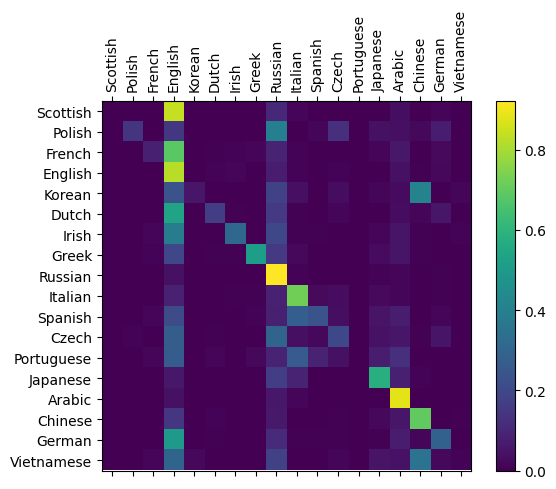

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(word_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.09) Russian
(-2.95) English
(-3.81) Czech

> Jackson
(-0.11) English
(-3.05) Russian
(-4.15) Scottish

> Satoshi
(-0.81) Japanese
(-1.46) Arabic
(-1.88) Italian
